In [146]:
#Here all imports will be done
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth",200)

# Importing Dataset

In [147]:
pos_tweets=twitter_samples.strings('positive_tweets.json')
neg_tweets=twitter_samples.strings('negative_tweets.json')
print("Positive tweets before Preprocessing:")
for i in range(5):
    print(i+1,"- ",pos_tweets[i])
print()
print("Negative tweets before Preprocessing:")
for i in range(5):
    print(i+1,"- ",neg_tweets[i])
print()
print("Total Positive tweets =",len(pos_tweets))
print("Total Negative tweets =",len(neg_tweets))

Positive tweets before Preprocessing:
1 -  #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
2 -  @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
3 -  @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
4 -  @97sides CONGRATS :)
5 -  yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days

Negative tweets before Preprocessing:
1 -  hopeless for tmr :(
2 -  Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(
3 -  @Hegelbon That heart sliding into the waste basket. :(
4 -  “@ketchBurning: I hate Japanese call him "bani" :( :(”

Me too
5 -  Dang starting next week I have "work" :(

Total Positive tweets = 5000
Total Negative tweets = 5000


# Pre-Processing

In [148]:
def pre_process(tweets):
    # (http[s]{0,1}://(\S)*)|(www\.[\S]+\.[\w]{1,6}) -> for matching url
    r1=re.compile(r'(http[s]{0,1}://(\S)*)|(www\.[\S]+\.[\w]{1,6})',re.A)
    # (^rt(\s)+)|([\s]rt[\s]*) -> for matching retweet(rt) at start or in between ...
    r2=re.compile(r'(^rt(\s)+)|([\s]rt[\s]*)',re.M)
    # @(\S)+ -> for matching @username ...
    r3=re.compile(r'@(\S)+',re.A)
    # #(\S)+ ->for matching #hashtags
    r4=re.compile(r'#(\S)+',re.A)
    # [^\w\s]+ -> for matching non word characters like symbols,emoticons,punctuations
    r5=re.compile(r'[^\w\s]+',re.A)
    stopword=stopwords.words('english') #imported a list of stopwords
    #print(stopword)
    processed_tweets=[]
    for tweet in tweets:
        tweet=tweet.lower() #converting tweet to lower case
        tweet=re.sub(r1," ",tweet)
        tweet=re.sub(r2," ",tweet)
        tweet=re.sub(r3," ",tweet)
        tweet=re.sub(r4," ",tweet)
        tweet=re.sub(r5," ",tweet)
        tweet=' '.join(tweet.split())
        #tokenization
        tokens=word_tokenize(tweet) 
        #removing stopwords
        filtered_words=[]
        for token in tokens:
            if token not in stopword:
                filtered_words.append(token)
        #stemming
        stemmed_words=[]
        ps=PorterStemmer()
        for word in filtered_words:
            stemmed_words.append(ps.stem(word))
        processed_tweet=' '.join(stemmed_words)
        processed_tweets.append(processed_tweet)
    return processed_tweets

In [150]:
processed_pos_tweets=pre_process(pos_tweets)
processed_neg_tweets=pre_process(neg_tweets)
print("Positive tweets after Preprocessing:")
for i in range(5):
    print(i+1,"- ",processed_pos_tweets[i])
print()
print("Negative tweets after Preprocessing:")
for i in range(5):
    print(i+1,"- ",processed_neg_tweets[i])

Positive tweets after Preprocessing:
1 -  top engag member commun week
2 -  hey jame odd pleas call contact centr 02392441234 abl assist mani thank
3 -  listen last night bleed amaz track scotland
4 -  congrat
5 -  yeaaaah yippppi accnt verifi rqst succeed got blue tick mark fb profil 15 day

Negative tweets after Preprocessing:
1 -  hopeless tmr
2 -  everyth kid section ikea cute shame nearli 19 2 month
3 -  heart slide wast basket
4 -  hate japanes call bani
5 -  dang start next week work


# Visualizing tweets

In [151]:
def plot_wordCloud(words):
    unique_string=(" ").join(words)
    wordcloud = WordCloud(width=800, height=500, background_color='grey', random_state=21, max_font_size=110).generate(unique_string)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

Positive Tweets Visualization


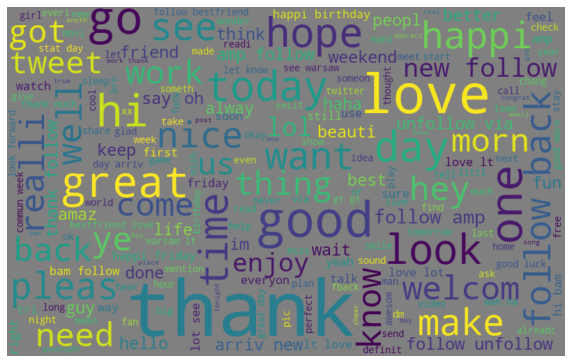

In [152]:
print("Positive Tweets Visualization")
plot_wordCloud(processed_pos_tweets)

Negative Tweets Visualization


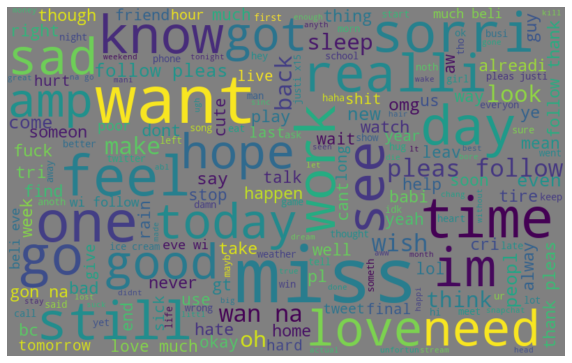

In [153]:
print("Negative Tweets Visualization")
plot_wordCloud(processed_neg_tweets)

# Feature Extraction

In [154]:
#TF-IDF on positive tweets
vectorizer_pos= TfidfVectorizer(min_df=5,max_df=0.75,ngram_range=(1,3),max_features=10000)
vectors=vectorizer_pos.fit_transform(processed_pos_tweets)
feature_names = vectorizer_pos.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()    
pos_df= pd.DataFrame(denselist, columns=feature_names)
pos_df

,000,10,100,11,12,13,15,16,17,20,...,year,yep,yesterday,yet,yo,youth,youth job,youth job opportun,youtub,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.616927,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
#TF-IDF on negative tweets
vectorizer_neg= TfidfVectorizer(min_df=5,max_df=0.75,ngram_range=(1,3),max_features=10000)
vectors=vectorizer_neg.fit_transform(processed_neg_tweets)
feature_names = vectorizer_neg.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
neg_df= pd.DataFrame(denselist, columns=feature_names)
neg_df

,07,10,100,11,12,15,20,2015,2015 07,24,...,ya,ye,yeah,year,yep,yesterday,yet,your,youtub,zayn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Scoring

In [156]:
#Scoring function for positive tweets
def pos_score(row):
    if(row['t_polarity']>2.0 and row['t_polarity']<=4.0):
        return 2
    if(row['t_polarity']>0.0 and row['t_polarity']<=2.0):
        return 1
    if(row['t_polarity']==0.0):
        return 0

In [157]:
#Giving scores to positive tweets
pos_df["t_polarity"]=pos_df.sum(axis=1)
pos_df['t_polarity'] =pos_df.apply(pos_score, axis='columns')
print(pos_df['t_polarity'].value_counts())
pos_df=pos_df.dropna()
pos_df

1.0    2857
2.0    1703
0.0     280
Name: t_polarity, dtype: int64


,000,10,100,11,12,13,15,16,17,20,...,yep,yesterday,yet,yo,youth,youth job,youth job opportun,youtub,yup,t_polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.616927,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [158]:
#Scoring function for negative tweets
def neg_score(row):
    if(row['t_polarity']>=2.0 and row['t_polarity']<=4.0):
        return -2
    if(row['t_polarity']>0.0 and row['t_polarity']<2.0):
        return -1
    if(row['t_polarity']==0.0):
        return 0

In [159]:
#Giving scores to negaive tweets
neg_df["t_polarity"]=neg_df.sum(axis=1)
neg_df['t_polarity'] =neg_df.apply(neg_score, axis='columns')
print(neg_df['t_polarity'].value_counts())
neg_df=neg_df.dropna()
neg_df

-1.0    2984
-2.0    1606
 0.0     365
Name: t_polarity, dtype: int64


,07,10,100,11,12,15,20,2015,2015 07,24,...,ye,yeah,year,yep,yesterday,yet,your,youtub,zayn,t_polarity
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


In [161]:
#Final dataframe
df= pos_df.append(neg_df, ignore_index=True)
print(df["t_polarity"].value_counts())
df.fillna(-99999,inplace=True)
df

-1.0    2984
 1.0    2857
 2.0    1703
-2.0    1606
 0.0     645
Name: t_polarity, dtype: int64


,000,10,100,11,12,13,15,16,17,20,...,wish could,woman,women,wors,worst,wtf,x15,xd,your,zayn
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.616927,0.0,0.0,0.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9790,-99999.0,0.0,0.0,0.0,0.0,-99999.0,0.000000,-99999.0,-99999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9791,-99999.0,0.0,0.0,0.0,0.0,-99999.0,0.000000,-99999.0,-99999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9792,-99999.0,0.0,0.0,0.0,0.0,-99999.0,0.000000,-99999.0,-99999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9793,-99999.0,0.0,0.0,0.0,0.0,-99999.0,0.000000,-99999.0,-99999.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Partitioning Dataframe into Label and Features dataframe

In [162]:
y=df["t_polarity"] # Label Dataframe
X=df.drop(["t_polarity"], 1) #Features Dataframe

### Partitioning into training and test set

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## A. SUPPORT VECTOR REGRESSION

In [164]:
from sklearn.svm import SVR
model_svr=SVR()
model_svr.fit(X_train,y_train)

SVR()

In [165]:
acc_svr=model_svr.score(X_test, y_test)

In [166]:
acc_svr

0.8176716983847339

In [226]:
y_pred_svr_test=model_svr.predict(X_test)
mae =mean_absolute_error(y_test,y_pred_svr_test)
print("Mean Absolute Error =",mae)

Mean Absolute Error = 0.42548486343925185


In [227]:
mse =mean_squared_error(y_test,y_pred_svr_test)
print("Mean Squared Error =",mse)

Mean Squared Error = 0.3484824755310748


## B. DECISION TREE

In [173]:
from sklearn.tree import DecisionTreeClassifier
model_dtree=DecisionTreeClassifier(random_state=2)
model_dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

In [174]:
y_pred_dtree_test=model_dtree.predict(X_test)
acc_dtree=metrics.accuracy_score(y_test, y_pred_dtree_test)

In [175]:
acc_dtree

0.8516502211636611

In [176]:
print(classification_report(y_test,y_pred_dtree_test))

              precision    recall  f1-score   support

        -2.0       0.87      0.81      0.84       488
        -1.0       0.90      0.85      0.87       912
         0.0       0.56      1.00      0.72       191
         1.0       0.92      0.85      0.88       879
         2.0       0.86      0.85      0.85       469

    accuracy                           0.85      2939
   macro avg       0.82      0.87      0.83      2939
weighted avg       0.87      0.85      0.86      2939



In [224]:
mae =mean_absolute_error(y_test,y_pred_dtree_test)
print("Mean Absolute Error =",mae)

Mean Absolute Error = 0.15039128955427017


In [225]:
mse =mean_squared_error(y_test,y_pred_dtree_test)
print("Mean Squared Error =",mse)

Mean Squared Error = 0.1544743109901327


## C.RANDOM FOREST

In [180]:
from sklearn.ensemble import RandomForestClassifier
model_rf= RandomForestClassifier()
model_rf.fit(X_train,y_train)

RandomForestClassifier()

In [181]:
y_pred_rf_test =model_rf.predict(X_test)
acc_rf=metrics.accuracy_score(y_test, y_pred_rf_test)

In [182]:
acc_rf

0.8489282068730861

In [183]:
print(classification_report(y_test,y_pred_rf_test))

              precision    recall  f1-score   support

        -2.0       0.96      0.70      0.81       488
        -1.0       0.85      0.89      0.87       912
         0.0       0.55      1.00      0.71       191
         1.0       0.88      0.90      0.89       879
         2.0       0.95      0.76      0.85       469

    accuracy                           0.85      2939
   macro avg       0.84      0.85      0.83      2939
weighted avg       0.87      0.85      0.85      2939



In [222]:
mae =mean_absolute_error(y_test,y_pred_rf_test)
print("Mean Absolute Error =",mae)

Mean Absolute Error = 0.1514120449132358


In [223]:
mse =mean_squared_error(y_test,y_pred_rf_test)
print("Mean Squared Error =",mse)

Mean Squared Error = 0.15209254848587955


## D. MULTINOMIAL LOGISTIC REGRESSION 

In [184]:
from sklearn.linear_model import LogisticRegression
model_lr= LogisticRegression(multi_class='multinomial',solver='newton-cg')
model_lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [185]:
y_pred_lr_test =model_lr.predict(X_test)
acc_lr=metrics.accuracy_score(y_test, y_pred_lr_test)

In [186]:
acc_lr

0.6753997958489282

In [187]:
print(classification_report(y_test,y_pred_lr_test))

              precision    recall  f1-score   support

        -2.0       0.71      0.34      0.46       488
        -1.0       0.66      0.93      0.77       912
         0.0       0.00      0.00      0.00       191
         1.0       0.68      0.90      0.77       879
         2.0       0.68      0.39      0.50       469

    accuracy                           0.68      2939
   macro avg       0.55      0.51      0.50      2939
weighted avg       0.64      0.68      0.63      2939



In [220]:
mae =mean_absolute_error(y_test,y_pred_lr_test)
print("Mean Absolute Error =",mae)

Mean Absolute Error = 0.32460020415107177


In [221]:
mse =mean_squared_error(y_test,y_pred_lr_test)
print("Mean Squared Error =",mse)

Mean Squared Error = 0.32460020415107177


Accuracies -
Support Vector Regression  =  81.7671698384734
Decision Tree  =  85.1650221163661
Random Forest  =  84.89282068730861
Multinomial Logistic Regression  =  67.53997958489282


<BarContainer object of 4 artists>

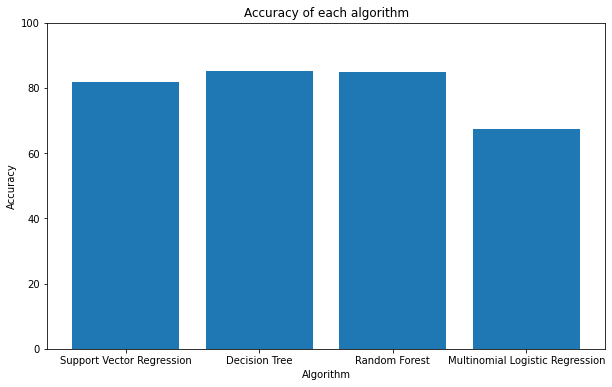

In [213]:
fig = plt.figure(figsize = (10, 6))
alg=['Support Vector Regression','Decision Tree','Random Forest','Multinomial Logistic Regression']
acc=[acc_svr*100,acc_dtree*100,acc_rf*100,acc_lr*100]
print("Accuracies -")
for i in range(4):
    print(alg[i]," = ",acc[i])
plt.ylabel('Accuracy')
plt.xlabel('Algorithm')
plt.title('Accuracy of each algorithm')
plt.ylim(0, 100) 
plt.bar(alg,acc)